In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from numpy.linalg import inv

In [344]:
np.random.seed(42)
N=20
w_orig = np.array([-3.0, 2.0])
x = np.random.uniform(-2, 3, N)
beta = 2.0 # noize precision (inverse variance)
# PHI = phi(x) # x with additional columns with ones
noize = np.random.normal(0.0, scale=1.0/np.sqrt(beta), size=N)
# t = np.sin(2*x) + noize # target
t = np.sin(2*x)+0.3*np.exp(x) + noize # target

### Frequentists' approach

In [345]:
def phi(x):
    return np.vstack((x,np.ones(x.shape[0]))).T

In [346]:
print(x.shape)
print(PHI.shape)
print(t.shape)

(20,)
(20, 7)
(20,)


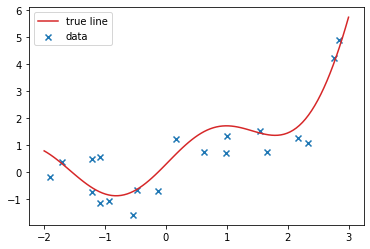

In [347]:
plt.scatter(x,t, marker="x", label="data")
x1 = np.linspace(-2,3,100)
plt.plot(x1,np.sin(2*x1)+0.3*np.exp(x1), c="tab:red", label="true line")
plt.legend()
plt.show()

In [348]:
from sklearn.preprocessing import PolynomialFeatures

In [349]:
poly = PolynomialFeatures(degree=6)
PHI = poly.fit_transform(x[:,np.newaxis])

In [350]:
w_ml = (inv(PHI.T.dot(PHI))).dot(PHI.T.dot(t))
beta_ml = N/np.sum((t-PHI.dot(w_ml))**2)

In [351]:
print("True parameters:", *w_orig)
print("Parameters:", *w_ml)
print("Noize variance: ", 1/beta_ml)

True parameters: -3.0 2.0
Parameters: -0.1313416419207485 2.1811754309924254 0.44011214749221494 -1.459401063702444 0.07147271172070191 0.25679922493575447 -0.04460751639190086
Noize variance:  0.25214072604405574


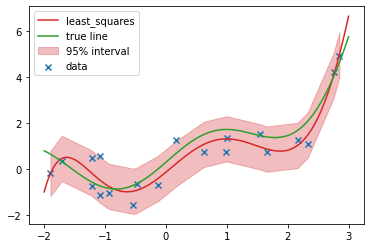

In [352]:
PHI1 = poly.fit_transform(x1[:, np.newaxis])
plt.fill_between(np.sort(x),y1=(PHI.dot(w_ml)+stats.norm.ppf(0.975, scale=1/np.sqrt(beta_ml)))[np.argsort(x)],
                 y2=(PHI.dot(w_ml)-stats.norm.ppf(0.975, scale=1/np.sqrt(beta_ml)))[np.argsort(x)],
                 color="tab:red", alpha=0.3, label="95% interval")
plt.scatter(x, t, marker="x", label="data")
plt.plot(x1,PHI1.dot(w_ml), c="tab:red", label="least_squares")
plt.plot(x1,np.sin(2*x1)+0.3*np.exp(x1), c="tab:green", label="true line")
# plt.plot(x1,np.sin(2*x1), c="tab:green", label="true line")
plt.legend()
plt.show()

### Bayesian approach

In [353]:
beta=25
data_x = x[:5]
data_PHI = PHI[:5]
data_y = t[:5]
# m0 = np.array([0,1,0,1,1])
m0 = np.zeros(7)
S0 = np.eye(7)*10

In [354]:
m1, S1 = m1_S1(m0, S0, data_y, beta, data_PHI)

In [355]:
def m1_S1(m0, S0, y, beta, PHI):
    if y.shape:
        S1 = inv(inv(S0) + beta*PHI.T@PHI)
        m1 = S1.dot(inv(S0).dot(m0) + beta*PHI.T.dot(y))
    else:
        S1 = inv(inv(S0) + beta*PHI[np.newaxis].T@PHI[np.newaxis])
        m1 = S1.dot(inv(S0).dot(m0) + beta*PHI.T*y)
    return m1, S1

In [356]:
x1 = np.linspace(-2,3,50)
data_PHI1 = poly.fit_transform(x1[:, np.newaxis])

In [357]:
sigmaN = 1/beta+np.diagonal(data_PHI1@S1@(data_PHI1.T))
muN = ((m1[np.newaxis]@(data_PHI1.T)))[0]

In [358]:
p1 = stats.norm.ppf(0.975, loc=muN, scale=np.sqrt(sigmaN))
p2 = stats.norm.ppf(0.025, loc=muN, scale=np.sqrt(sigmaN))
l1 = stats.norm.ppf(0.9, loc=0, scale=np.sqrt(sigmaN))

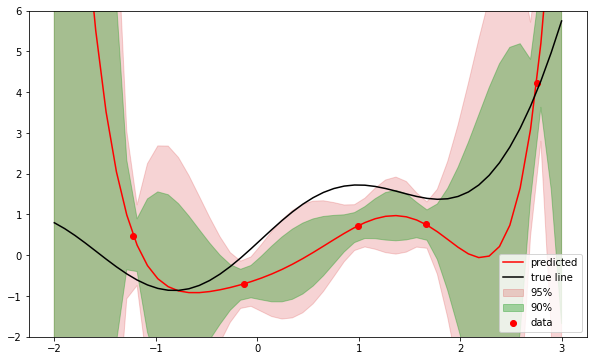

In [359]:
plt.figure(figsize=(10,6))
plt.fill_between(x1,y1=p1,y2=p2,color="tab:red", alpha=0.2, label="95%")
plt.fill_between(x1,y1=l1+muN,y2=muN-l1,color="tab:green", alpha=0.4, label="90%")
plt.plot(x1, muN,"r", label="predicted")
plt.plot(x1,np.sin(2*x1)+0.3*np.exp(x1), c="black", label="true line")
plt.scatter(data_x, data_y, c="r", label="data")
plt.legend()
plt.ylim([-2,6])
plt.show()